# **<font color=white> 08.Random Forest Code 실습**

[목적]
  1. Decision Tree 실습 및 해석
  2. Variance를 낮추기위한 Bagging의 대표적인 모델 RandomForest 실습 및 해석

[Process]
  1. Define X's & Y
  2. Split Train & Valid dataset
  3. Modeling
  4. Model 해석

# 환경설정

In [1]:
import os
import gc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from collections import Counter
from sklearn import tree

# 데이터

In [2]:
# Data Loading (수술 時 사망 데이터)
data = pd.read_csv("https://raw.githubusercontent.com/GonieAhn/Data-Science-online-course-from-gonie/main/Data%20Store/example_data.csv")

In [3]:
data

,censor,event,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,gender,str2,strat,symptom,cd40,cd420,cd496,r,cd80,cd820
0,0,1090,43,66.679,0,1,0,100,0,1,...,1,1,3,0,504,353,660,1,870,782
1,1,794,31,73.030,0,1,0,100,0,1,...,1,1,3,0,244,225,106,1,708,699
2,0,957,41,66.226,0,1,1,100,0,1,...,1,1,3,0,401,366,453,1,889,720
3,1,188,35,78.019,0,1,0,100,0,1,...,1,1,3,0,221,132,-1,0,221,759
4,1,308,40,83.009,0,1,0,100,0,1,...,1,1,3,1,150,90,20,1,1730,1160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,0,1097,24,71.000,1,0,0,100,0,1,...,1,1,2,0,364,475,734,1,770,802
528,1,154,21,52.300,1,0,0,90,0,1,...,1,1,2,0,415,181,84,1,949,666
529,1,588,16,63.000,1,0,0,100,0,1,...,1,1,3,0,299,214,124,1,546,471
530,0,395,17,102.967,1,0,0,100,0,1,...,1,1,3,0,373,218,-1,0,1759,1030


[Data DESCR]

Brief Description

The original paper describing the trial is Hammer, S. M., Katzenstein, D. A., Hughes, M. D., Gundaker, H., Schooley, R. T., Haubrich, R. H., Henry, W. K., Lederman, M. M., Phair, J. P., Niu, M., Hirsch, M. S., and Merigan, T. C., for the Aids Clinical Trials Group Study 175 Study Team (1996). A trial comparing nucleoside monotherapy with combination therapy in HIV-infected adults with CD4 counts from 200 to 500 per cubic millimeter. The New England Journal of Medicine, 1081-1089.

Linear regression of response = cd4 count at 20 +- 5 weeks (cd420) was used in Tsiatis, A.A., Davidian, M., Zhang, M., and Lu, X. (2008), "Covariate adjustment for two-sample treatment comparisons in randomized clinical trials: A principled yet flexible approach," Statistics in Medicine.

Cox regression of response = time to death (event) was used in Lu X, Tsiatis AA (2008), "Improving the efficiency of the logrank test using auxiliary covariates," Biometrika.

In the text file above, the variables are named

- censor     :     censoring indicator = 1 if dead = 0 if censored
- event      :     event time
- age        :     age (yrs) at baseline
- wtkg       :     weight (kg) at baseline
- hemo       :     hemophilia (0=no, 1=yes)
- homo       :     homosexual activity (0=no, 1=yes)
- drugs      :     history of IV drug use (0=no, 1=yes)
- karnof     :     Karnofsky score (on a scale of 0-100)
- oprior     :     Non-ZDV antiretroviral therapy pre-175 (0=no, 1=yes)
- z30        :     ZDV in the 30 days prior to 175 (0=no, 1=yes)
- zprior     :     ZDV prior to 175 (0=no, 1=yes)
- preanti    :     # days pre-175 anti-retroviral therapy
- race       :     race (0=White, 1=non-white)
- gender     :     gender (0=F, 1=M)
- str2       :     antiretroviral history (0=naive, 1=experienced)
- strat      :     antiretroviral history stratification (1='Antiretroviral Naive',2='> 1 but <= 52 weeks of prior antiretroviral therapy',3='> 52 weeks)
- symptom    :     symptomatic indicator (0=asymp, 1=symp)
- cd40       :     baseline cd4
- cd420      :     cd4 count at 20 +- 5 weeks
- cd496      :     cd4 count at 96 +- 5 weeks (missing for a lot of subjects)
- r          :     missingness indicator for cd496
- cd80       :     baseline cd8 count
- cd820      :     cd8 count at 20 +- 5 weeks

In [4]:
data.shape[1]

23

In [5]:
data.describe()

,censor,event,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,gender,str2,strat,symptom,cd40,cd420,cd496,r,cd80,cd820
count,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,...,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000
mean,0.340226,801.236842,35.225564,76.061855,0.078947,0.640977,0.118421,95.432331,0.030075,0.546992,...,0.812030,0.580827,1.981203,0.167293,353.204887,336.139098,173.146617,0.603383,987.250000,928.214286
std,0.474231,326.887929,8.852094,13.224698,0.269910,0.480165,0.323410,5.981856,0.170955,0.498255,...,0.391056,0.493888,0.905946,0.373589,114.105253,130.961573,191.455406,0.489656,475.223907,438.569798
min,0.000000,33.000000,13.000000,47.401000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,103.000000,49.000000,-1.000000,0.000000,221.000000,150.000000
25%,0.000000,535.750000,29.000000,67.500000,0.000000,0.000000,0.000000,90.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,271.000000,243.750000,-1.000000,0.000000,653.250000,626.500000
50%,0.000000,933.500000,34.000000,74.600000,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,1.000000,2.000000,0.000000,346.000000,330.500000,113.000000,1.000000,881.000000,818.000000
75%,1.000000,1081.000000,40.000000,83.502000,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,1.000000,3.000000,0.000000,422.000000,418.000000,324.000000,1.000000,1190.000000,1164.000000
max,1.000000,1231.000000,70.000000,149.000000,1.000000,1.000000,1.000000,100.000000,1.000000,1.000000,...,1.000000,1.000000,3.000000,1.000000,771.000000,909.000000,857.000000,1.000000,4255.000000,3130.000000


## [ISSUE]


 ### - Tree 계열은 Scaling이 필요한가?

 필요하지 않다. 변수들끼리 서로 정보를 교환하지 않으므로.  불순도 계산은 독립적으로 이루어짐.

### F1 Score

In [ ]:
# Label Balace Check - Imbalance
Counter(data['censor'])

Counter({0: 351, 1: 181})

* 0 이 351개, 1이 181개. 2배 정도 차이가 남.
* 이 정도면 모델이 학습할 수 있음
* 지표는 Acc(Accuracy)가 아닌, (Recall, Precision, ACC 모두를 고려한)F1_Score 를 봐야하겠다.  

* 만약 0:1 이 5:5 라면 ACC 지표만 봐도 된다.

### Preprocessing

In [6]:
# X's & Y Split
Y = data['censor']
X = data.drop(columns=['censor'])

In [7]:
data.shape

(532, 23)

In [8]:
X.shape

(532, 22)

In [9]:
Y.shape

(532,)

> 인덱스

In [10]:
idx = list(range(X.shape[0]))
train_idx, valid_idx = train_test_split(idx, test_size=0.3, random_state=2023)
print(">>>> # of Train data : {}".format(len(train_idx)))
print(">>>> # of valid data : {}".format(len(valid_idx)))
print(">>>> # of Train data Y : {}".format(Counter(Y.iloc[train_idx])))
print(">>>> # of valid data Y : {}".format(Counter(Y.iloc[valid_idx])))

>>>> # of Train data : 372
>>>> # of valid data : 160
>>>> # of Train data Y : Counter({0: 250, 1: 122})
>>>> # of valid data Y : Counter({0: 101, 1: 59})


# [Decision Tree를 활용한 Rule Extraction]

 - Max_Depth는 5 초과를 넘지 않아야함, 5를 초과하게 되면 Rule Extraction Plotting의 가독성이 매우 떨어짐 (해석력을 가지려면 5도 크다, 3 정도가 적당)
 - 정확도와 설명력은 Trade-off가 존재하기 때문에 자기만의 기준으로 적절한 선을 선택하면 됨
 - Rule Extraction 할때 GINI INDEX 뿐만 아니라 Sample 개수도 중요한 척도가 됨
GINI INDEX가 아주 낮지만(불순도가 낮음, 좋음) Sample의 개수가 너무 적으면 의미가 없음(Overfitting이라고 생각됨)

## Depth 조절 Decision Tree



---

이 코드는 Decision Tree 분류기(Decision Tree Classifier)를 사용하여 모델의 깊이(max_depth)를 조절하면서 훈련 및 검증 데이터셋에 대한 성능을 평가하는 과정을 보여줍니다

In [11]:
# Depth 조절 Decision Tree

# 깊이 2부터 10까지 1씩 증가시키면서 반복하는 루프입니다.
# 각 반복에서 다른 깊이를 가진 Decision Tree 모델을 생성하고 평가합니다.
for i in range(2,11,1):
    print(">>>> Depth {}".format(i))

    ## max_depth가 i인 Decision Tree 분류기를 생성합니다.
    ## criterion='gini'는 지니 불순도를 기준으로 분할을 수행하도록 설정합니다.
    model = DecisionTreeClassifier(max_depth=i, criterion='gini')
    ## 주어진 훈련 데이터(X.iloc[train_idx], Y.iloc[train_idx])를 사용하여 모델을 학습시킵니다.
    model.fit(X.iloc[train_idx], Y.iloc[train_idx])

    # Train Acc

    ## 훈련 데이터에 대한 예측 결과
    y_pre_train = model.predict(X.iloc[train_idx])
    ## confusion matrix 계산
    cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
    print("Train Confusion Matrix")
    print(cm_train)
    ## confusion matrix 출력 후 정확도(Accuracy)와 F1 점수를 계산하고 출력.
    ## (cm_train[0,0] + cm_train[1,1])/cm_train.sum() <= 정확도
    print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
    ## f1_score(Y.iloc[train_idx], y_pre_train) <= F1 점수
    print("Train F1-Score : {}".format(f1_score(Y.iloc[train_idx], y_pre_train)))

    # Test Acc

    ## 검증 데이터에 대한 예측 결과
    y_pre_test = model.predict(X.iloc[valid_idx])
    ## ## confusion matrix 계산
    cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
    print("Train Confusion Matrix")
    print(cm_test)
    ## confusion matrix 출력 후 정확도(Accuracy)와 F1 점수를 계산하고 출력.
    ## (cm_test[0,0] + cm_test[1,1])/cm_test.sum() <= 정확도
    print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
    ## f1_score(Y.iloc[valid_idx], y_pre_test) <= F1 점수
    print("Test F1-Score : {}".format(f1_score(Y.iloc[valid_idx], y_pre_test)))
    print("-----------------------------------------------------------------------")
    print("-----------------------------------------------------------------------")

>>>> Depth 2
Train Confusion Matrix
[[241   9]
 [ 44  78]]
Train Acc : 0.8575268817204301
Train F1-Score : 0.7464114832535885
Train Confusion Matrix
[[97  4]
 [26 33]]
TesT Acc : 0.8125
Test F1-Score : 0.6874999999999999
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>>> Depth 3
Train Confusion Matrix
[[228  22]
 [ 18 104]]
Train Acc : 0.8924731182795699
Train F1-Score : 0.8387096774193549
Train Confusion Matrix
[[87 14]
 [13 46]]
TesT Acc : 0.83125
Test F1-Score : 0.773109243697479
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>>> Depth 4
Train Confusion Matrix
[[227  23]
 [ 10 112]]
Train Acc : 0.9112903225806451
Train F1-Score : 0.8715953307392996
Train Confusion Matrix
[[90 11]
 [11 48]]
TesT Acc : 0.8625
Test F1-Score : 0.8135593220338985
-------------------------------------------------

* 5 depth에서 F1 Score 떨어짐. Overfitting 됐다는 뜻.  
* Decision Tree 분류기 모델을 깊이 4로 설정하고, 주어진 훈련 데이터셋을 사용하여 모델을 학습시킵니다.

In [12]:
# Depth가 깊어질 수록 정확도는 높게 나오지만 해석력에 대한 가독성을 위해 Depth 5를 선택함
model = DecisionTreeClassifier(max_depth=4, criterion='gini') ## 깊이 4로 제한된 Decision Tree 분류기 객체를 생성
model.fit(X.iloc[train_idx], Y.iloc[train_idx]) ## 훈련 데이터(X.iloc[train_idx], Y.iloc[train_idx])를 사용하여 모델을 학습시킴.

DecisionTreeClassifier(max_depth=4)

학습된 Decision Tree 모델을 시각화하여 플롯으로 표시

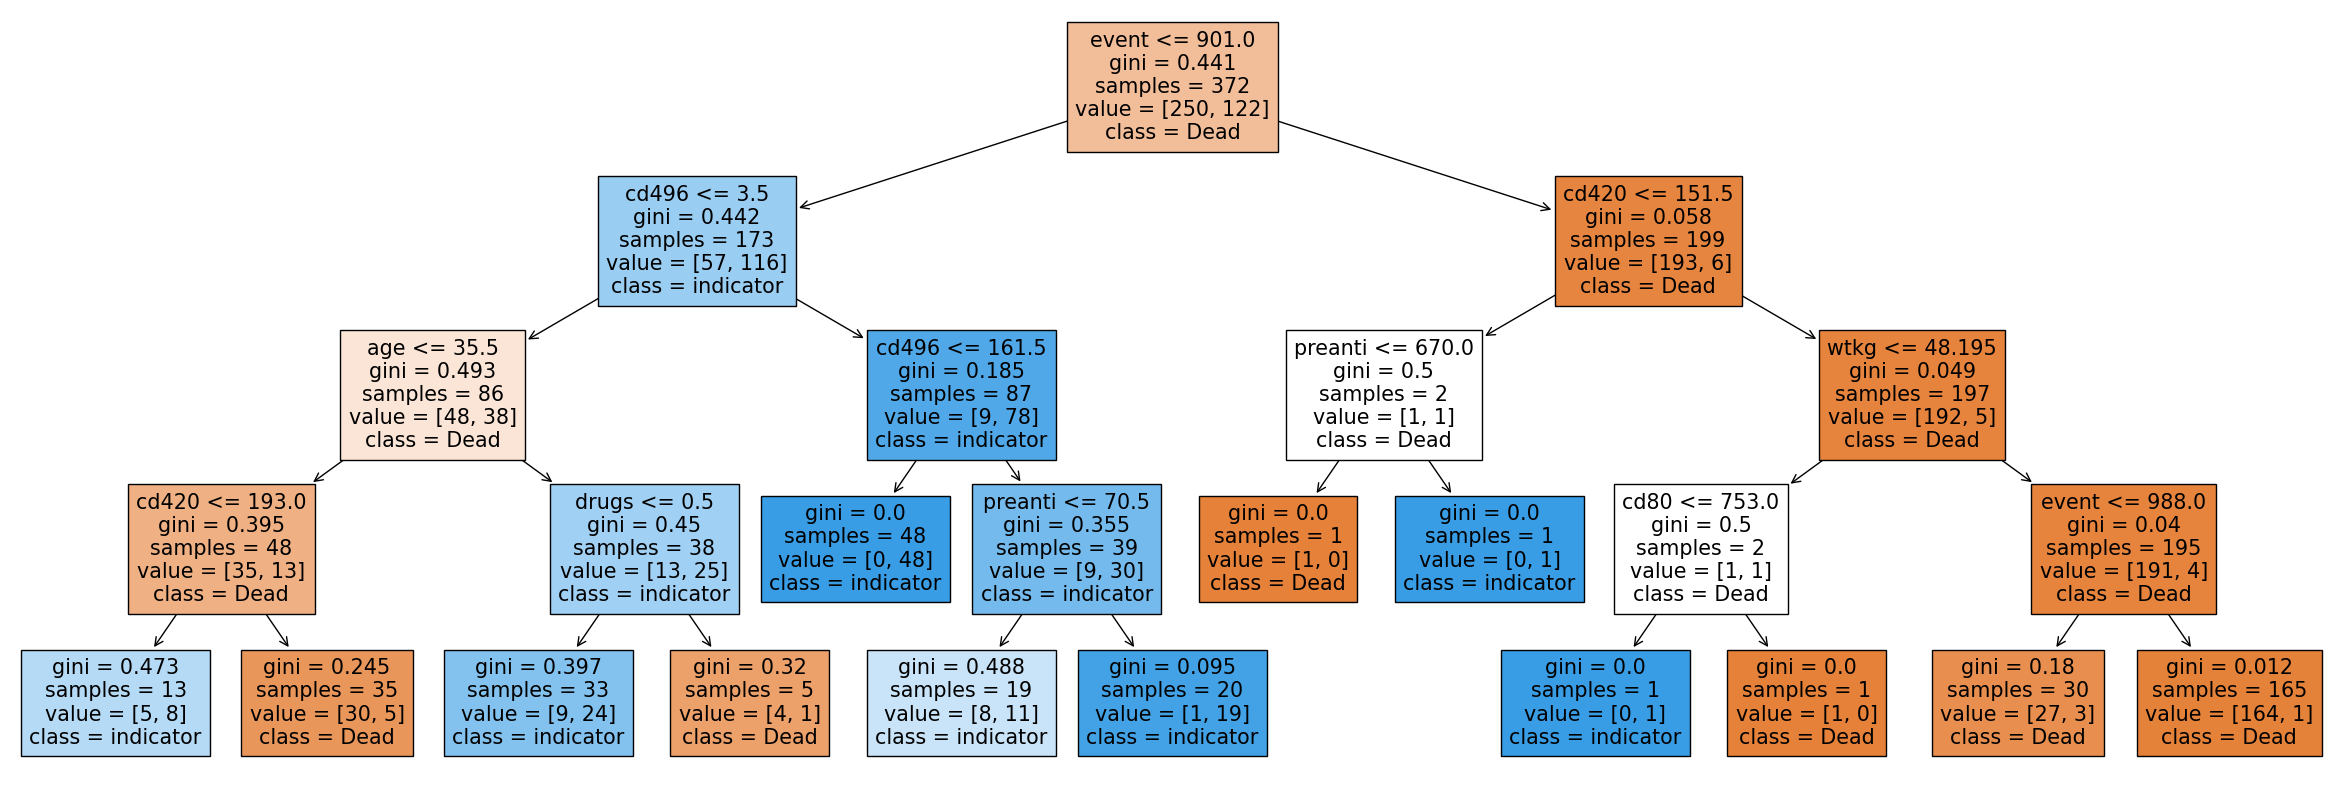

In [14]:
# Creating the tree plot

## model은 학습된 Decision Tree 모델입니다.
## filled=True는 각 노드의 색상을 클래스에 따라 채웁니다.
## feature_names=X.columns는 특성(피처) 이름을 표시합니다.
## class_names=['Dead', 'indicator']는 클래스 이름을 표시합니다.
tree.plot_tree(model, filled=True, feature_names=X.columns, class_names = ['Dead', 'indicator'])
plt.rcParams['figure.figsize'] = [30,10]  ## 플롯의 크기를 30x10 인치로 설정

* 첫 노드 event: split 후 불순도가 가장 낮은 split point 선택
* 왼쪽이 True, 오른쪽이 False
* 첫노드 기준으로 901보다 작으면 왼쪽, 크면 오른쪽(901보다 크면 사망한다 판단)
* gini index 도 중요하지만, 샘플 개수도 중요. 샘플 개수가 적은 것은 의미없음.
* gini = 0 (파랑색): full tree 불순도 0

# [Random Forest]

 - Hyperparameter tuning
 - estimators, depth
 - Random Forest는 이 두개만 조절해도 좋은 결과를 얻을 수 있음
 - GridSearchCV를 사용하지 않고 For Loop를 돌리는 이유
    - 내가 원하는 결과를 저장하고 Display 하고 싶음
    - 내가 원하는 결과를 실시간 Display 하면서 그때 그때 파라미터 튜닝에 대한 대처를 하고 싶음

[Random Forest Parameters]

> ⭐ estimator 와 ⭐ max depth 만 조정해 주면 됨

  - Package : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
  - ⭐ n_estimators : # of Tree 몇 개의 트리 만들 건지.
  - criterion : Measuring for Split (Information gain) - split 방법
     - Gini
     - entropy
     - log_loss
  - ⭐ max_depth : Tree의 최대 깊이 제한
  - min_samples_split : 2개로 Split 하는게 아니라 N개로 Split 가능
  - bootstrap : Bagging 중 Boostrap(복원추출) 기법 - False 로 사용하면 랜덤포레스트 의미 없음
  - max_features : Feature 수 sampling
     - auto
     - sqrt
     - log2
  - oob_score : out-of-bag Score - 한번도 데이터에서 추출되지 않은 것을 가지고 score를 보는 것
  - class_weight : Label Imbalance 데이터 학습시 weight를 주는 것
     - {0: 1, 1: 1}
  - random_state : Two way Random Choosen 때문에 매 결과가 달라짐
     - 지정한 값으로 해주는 것이 결과가 같아짐



---


다양한 하이퍼파라미터 설정으로 Random Forest 모델을 학습하고 평가합니다.

다양한 하이퍼파라미터 조합에 대한 모델 성능을 비교하여 최적의 RandomForest 모델을 찾는 데 도움을 줍니다.

In [15]:
# RandomForest Hyperparameter
## 하이퍼파라미터 설정, estimators는 사용할 트리의 개수, depth는 트리의 최대 깊이
estimators = [10, 30, 40, 50, 60]
depth = [4 , 5, 10, 15]

# Modeling
## 각각 사용한 트리 개수, 최대 깊이, F1 점수를 저장하는 리스트
save_est = []
save_dep = []
f1_score_ = []

## 이중 for 루프를 통해 각 하이퍼파라미터 조합에 대해 모델을 학습하고 평가합니다.
cnt = 0
for est in estimators:
    for dep in depth:
        print(">>> {} <<<".format(cnt))
        cnt += 1
        print("Number of Estimators : {}, Max Depth : {}".format(est, dep))

        ## 주어진 하이퍼파라미터로 RandomForest 모델을 생성합니다.
        model = RandomForestClassifier(n_estimators=est, max_depth=dep, random_state=119,
                                       criterion='gini', max_features='auto',
                                       bootstrap=True, oob_score=False) # if you use "oob_score=True", get long time for training
        ## 훈련 데이터를 사용하여 모델을 학습시킵니다.
        model.fit(X.iloc[train_idx], Y.iloc[train_idx])

        # Train Acc : 훈련 데이터 성능 평가
        y_pre_train = model.predict(X.iloc[train_idx])  ## 예측값 얻기
        cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)  ## confusion matrix 계산
        print("Train Confusion Matrix")
        print(cm_train)
        print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
        print("Train F1-Score : {}".format(f1_score(Y.iloc[train_idx], y_pre_train)))

        # Test Acc : 검증 데이터 성능 평가
        y_pre_test = model.predict(X.iloc[valid_idx])  ## 예측값 얻기
        cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)  ## confusion matrix 계산
        ## 각 하이퍼파라미터 조합에 대한 결과를 출력하고, 평가 결과(F1 점수)를 save_est, save_dep, f1_score_에 저장
        print("Test Confusion Matrix")
        print(cm_test)
        print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
        print("Test F1-Score : {}".format(f1_score(Y.iloc[valid_idx], y_pre_test)))
        print("-----------------------------------------------------------------------")
        print("-----------------------------------------------------------------------")
        save_est.append(est)
        save_dep.append(dep)
        f1_score_.append(f1_score(Y.iloc[valid_idx], y_pre_test))

>>> 0 <<<
Number of Estimators : 10, Max Depth : 4
Train Confusion Matrix
[[242   8]
 [ 29  93]]
Train Acc : 0.9005376344086021
Train F1-Score : 0.8340807174887892
Test Confusion Matrix
[[93  8]
 [26 33]]
TesT Acc : 0.7875
Test F1-Score : 0.6599999999999999
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 1 <<<
Number of Estimators : 10, Max Depth : 5
Train Confusion Matrix
[[243   7]
 [ 14 108]]
Train Acc : 0.9435483870967742
Train F1-Score : 0.9113924050632911
Test Confusion Matrix
[[90 11]
 [23 36]]
TesT Acc : 0.7875
Test F1-Score : 0.679245283018868
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 2 <<<
Number of Estimators : 10, Max Depth : 10
Train Confusion Matrix
[[249   1]
 [  3 119]]
Train Acc : 0.989247311827957
Train F1-Score : 0.9834710743801653
Test Confusion Matrix
[[93  8]
 [

> 10 depth 일때 Test F1 Score 0.82456...으로 가장 높음.



---

이전에 저장한 F1 점수를 기반으로 최적의 RandomForest 모델을 선택하고 학습시킵니다.


## Best Model

In [19]:
# Best Model

## best_model은 해당 하이퍼파라미터로 최적의 RandomForest 모델을 생성
## save_est[np.argmax(f1_score_)]와 save_dep[np.argmax(f1_score_)]는 F1 점수가 가장 높은 모델의 트리 개수와 최대 깊이
best_model = RandomForestClassifier(n_estimators = save_est[np.argmax(f1_score_)], max_depth =save_dep[np.argmax(f1_score_)], random_state=119,
                               criterion='gini', max_features='auto',
                               bootstrap=True, oob_score=False) # if you use "oob_score=True", get long time for training
## best_model.fit(X.iloc[train_idx], Y.iloc[train_idx])는 훈련 데이터를 사용하여 최적의 모델을 학습시킵니다
best_model.fit(X.iloc[train_idx], Y.iloc[train_idx])

RandomForestClassifier(max_depth=10, max_features='auto', n_estimators=40,
                       random_state=119)

> 10 depth, 40 estimator 일 때 가장 좋은 성과

In [20]:
# Train Acc
y_pre_train = best_model.predict(X.iloc[train_idx])
cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
print("Train Confusion Matrix")
print(cm_train)
print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
print("Train F1-Score : {}".format(f1_score(Y.iloc[train_idx], y_pre_train)))

# Test Acc
y_pre_test = best_model.predict(X.iloc[valid_idx])
cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
print("Test Confusion Matrix")
print(cm_test)
print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
print("Test F1-Score : {}".format(f1_score(Y.iloc[valid_idx], y_pre_test)))

Train Confusion Matrix
[[250   0]
 [  0 122]]
Train Acc : 1.0
Train F1-Score : 1.0
Test Confusion Matrix
[[93  8]
 [12 47]]
TesT Acc : 0.875
Test F1-Score : 0.8245614035087718


## Feature Importance Score

내림차순

In [21]:
feature_map = pd.DataFrame(sorted(zip(best_model.feature_importances_, X.columns), reverse=True), columns=['Score', 'Feature'])
print(feature_map)

       Score  Feature
0   0.325071    event
1   0.116611    cd420
2   0.080297    cd496
3   0.068333     cd80
4   0.066404     wtkg
5   0.064655    cd820
6   0.062691     cd40
7   0.054047      age
8   0.047875  preanti
9   0.036185        r
10  0.013194   karnof
11  0.011671    strat
12  0.011409     race
13  0.006760    drugs
14  0.006678   gender
15  0.006291     hemo
16  0.006121     homo
17  0.005438  symptom
18  0.005390      z30
19  0.004878     str2
20  0.000000   zprior
21  0.000000   oprior


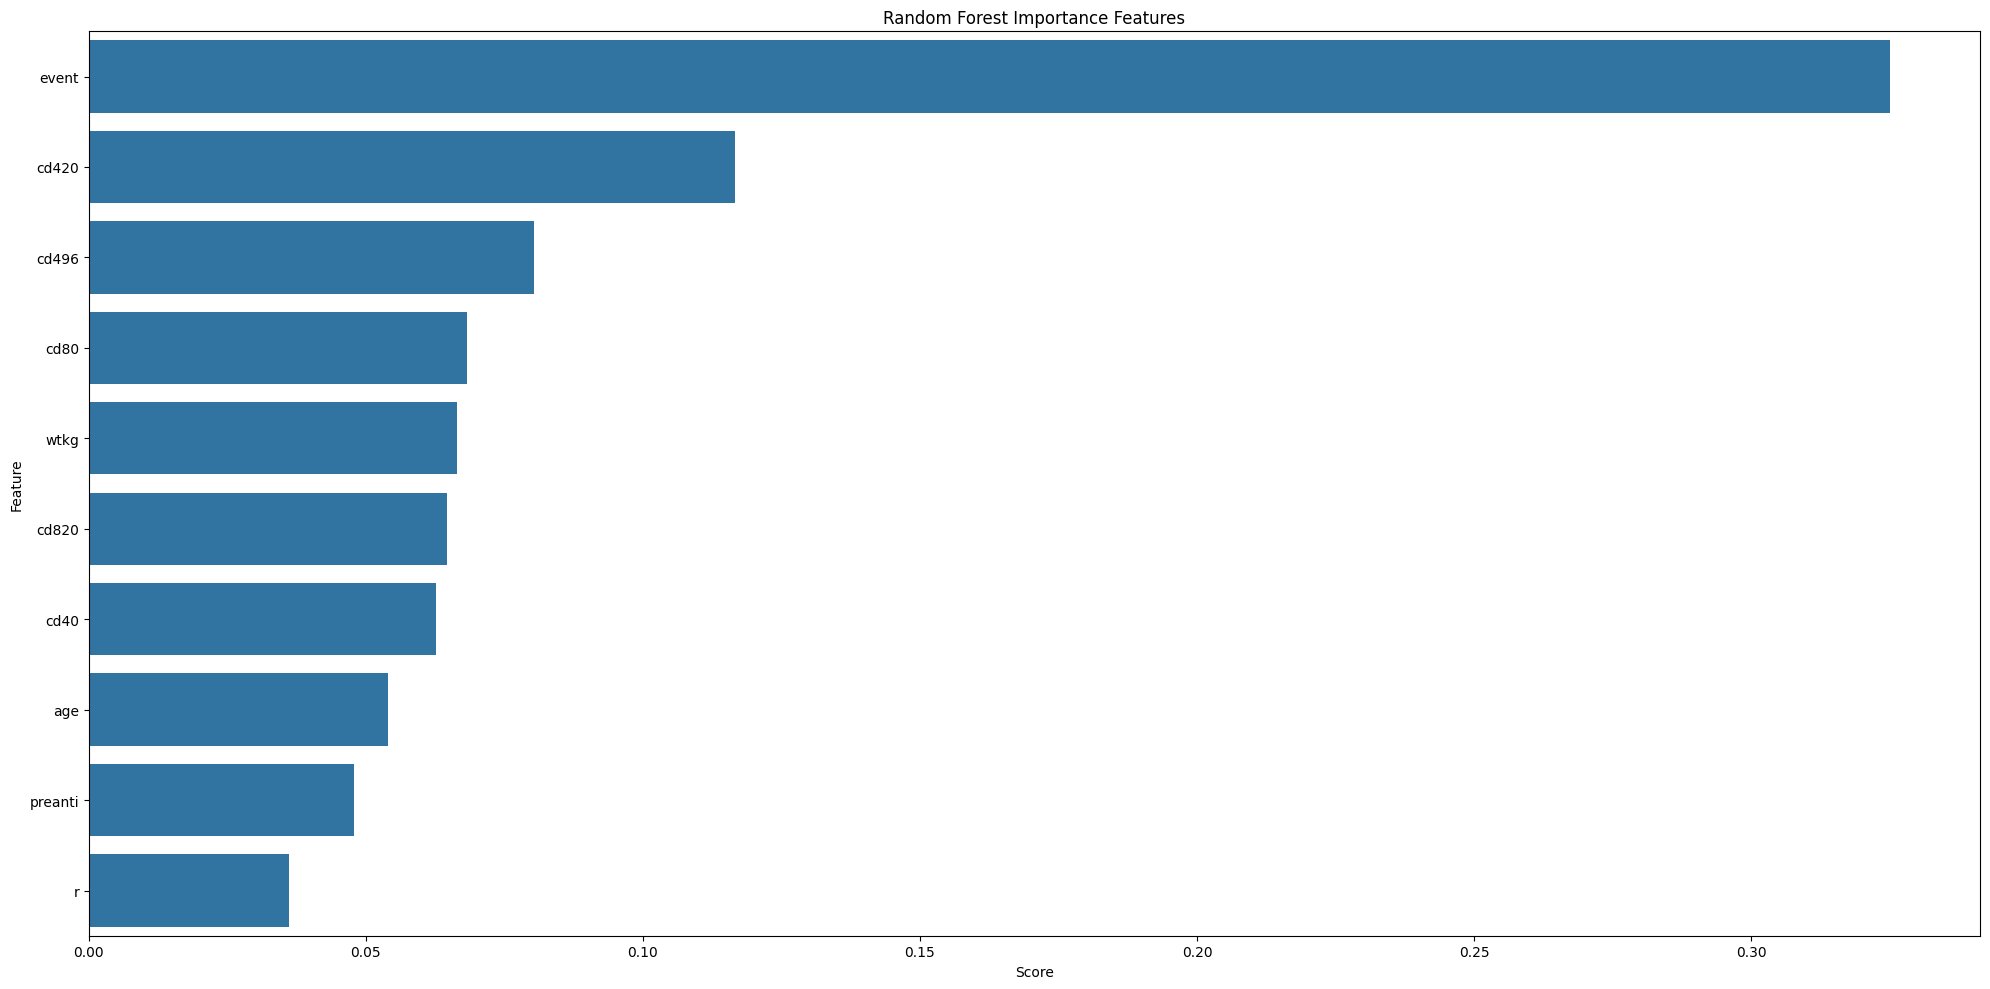

In [23]:
# Importance Score Top 10
feature_map_20 = feature_map.iloc[:10]
plt.figure(figsize=(20, 10))
sns.barplot(x="Score", y="Feature", data=feature_map_20.sort_values(by="Score", ascending=False), errwidth=40)
plt.title('Random Forest Importance Features')
plt.tight_layout()
plt.show()

이것만 가지고 Randomforest로 또 Rull Extention 을 해본다.